In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import six
from six.moves import range

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
X = np.loadtxt('iris.data', dtype='object', delimiter=',')
Y = X[:,-1]
X = X[:, :-1].astype('f')
X.shape, Y.shape, Y.dtype

((150, 4), (150,), dtype('O'))

`X` is a `NxK` float matrix where each row (`X[i]`) corresponds to a data point.

In [4]:
def e_step(X, N, D, w, mean, cov, n_clusters):
    
    p = np.zeros((N, n_clusters)) # co-prob matrix
    
    scale = np.linalg.det(cov) ** -.5 # scaling of pdf
    Z = (2*np.pi)**(D/2.) #inverse partition function
    
    for cluster_ind in range(n_clusters):
        dist = np.exp(-.5 * np.einsum('ij, ij -> i', X - mean[cluster_ind], np.dot(np.linalg.inv(cov[cluster_ind]) , (X - mean[cluster_ind]).T).T ) ) # mahalanobis distance
        p[:, cluster_ind] = w[cluster_ind] * scale[cluster_ind] * (1./Z) * dist #mult by class priors
    
    return (p.T / np.sum(p, axis = 1)).T     #divided to find posterior probability

def m_step(responsibilities, w, N, X, n_clusters, cov, mean):
    eff_N = np.sum(responsibilities, axis=0) # eff num in cluster
        
    w = eff_N / N # update cluster priors
    mean = (responsibilities.T @ X) / eff_N.T[:, np.newaxis] # and means
        
    for cluster_ind in range(n_clusters):
        cov[cluster_ind] = (1. / eff_N[cluster_ind]) * np.dot((responsibilities[:,cluster_ind].reshape(X.shape[0],1) * (X - mean[cluster_ind]) ).T, X - mean[cluster_ind])
    
    # when the number of clusters is large, occasionally may have singular covariance estimates, adding noise
    #cov += np.eye(X.shape[1]) * 1e-9
    return w, mean, cov

def gmm(X, n_classes, n_iter):
    n_clusters = n_classes 
    (N, D) = X.shape
    
    w = np.ones(n_clusters) * (1.0 / n_clusters)
    mean = X[np.random.choice(N, n_clusters, False)]
    cov = np.array([np.eye(D)] * n_clusters)

    for epoch in range(n_iter):
        # Perform E-step to calculate the responsibilities matrix
        responsibilities = e_step(X, N, D, w, mean, cov, n_clusters) 
        
        # Perform M-step to maximize (w, mean, cov)
        w, mean, cov = m_step(responsibilities, w, N, X, n_clusters, cov, mean)
        
    # vector of most probable class for each obj
    class_assignments = np.argmax(responsibilities, axis=1)
    
    return class_assignments, mean, cov

In [5]:
class_assignments, mean, cov = gmm(X, 2, 500)  # You may want to tune the number of iterations

## Visualization: a Cross Section

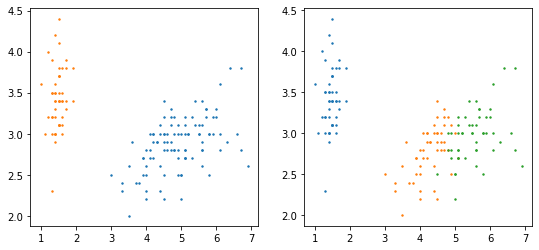

In [6]:
plt.figure(figsize=(9,4))
plt.subplot(121)
for k in range(3):
    plt.scatter(X[class_assignments==k, 2], X[class_assignments==k, 1], s=2)
plt.subplot(122)
for k, class_name in enumerate(np.unique(Y)):
    plt.scatter(X[Y==class_name, 2], X[Y==class_name, 1], s=2)
plt.savefig("Cluster-.png")

## Visualization: PCA Projection

In [7]:
evals, evecs = np.linalg.eigh(np.cov(X.T))
to_crd = lambda x: ((x-x.mean(axis=0))@evecs)[:,-2:]
crds = to_crd(X)

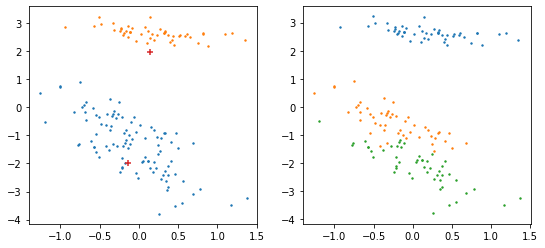

In [8]:
plt.figure(figsize=(9,4))
plt.subplot(121)
for k in range(3):
    plt.scatter(crds[class_assignments==k, 0], crds[class_assignments==k, 1], s=2)
plt.scatter(to_crd(mean)[:,0], to_crd(mean)[:,1], s=30, marker='+')
plt.subplot(122)
for k in np.unique(Y):
    plt.scatter(crds[Y==k, 0], crds[Y==k, 1], s=2)
plt.savefig("PCA-Cluster-.png")